In [1]:
import numpy as np
import scipy as sp
from math import pi, tanh
from cmath import sqrt
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact

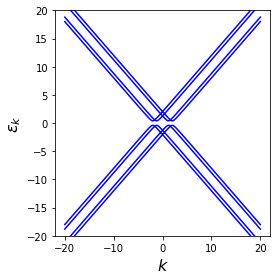

In [24]:
D1=0.0
D1t=0
D2=0.4
k0u=2.
k0d=1.2
vF=1


s0=np.array([[1,0],[0,1]])
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1j],[1j,0]])
sz=np.array([[1,0],[0,-1]])
s_up=(sz+s0)/2
s_dn=(s0-sz)/2

k_sw= np.linspace(-1,1,4001)*20
Ens= np.zeros((len(k_sw),8))
for i_k in range(len(k_sw)):
    Ham= vF*k_sw[i_k]* np.kron(s0,np.kron(sz,s0))\
        - k0u* np.kron(sz,np.kron(s0,s_up))\
        - k0d* np.kron(sz,np.kron(s0,s_dn))\
        + D1*np.kron(sy,np.kron(sx,sy))\
        + D1t*np.kron(sy,np.kron(s0,sy))\
        + D2*np.kron(sy,np.kron(sy,s0))
    Ens[i_k,:], _ = np.linalg.eigh(Ham)
#        + D1*np.kron(sy,np.kron(sx,sy))\

    
plt.figure(figsize=(4,4))
plt.plot(k_sw,Ens,'b')

plt.xlabel('k')
plt.ylabel('E')
fsize=16
plt.ylabel(r"$\varepsilon_k$",fontsize = fsize)
plt.xlabel(r"$k$",fontsize = fsize)
plt.ylim(-20,20)
# plt.xlim(-1,4)
# plt.xticks([0,2,4])
# plt.yticks(np.arange(-2,2.1,1))
# plt.grid()
plt.tight_layout()
# plt.savefig('figs/nu2_eff_D12_%d_%d.pdf' % (100*D1,100*D2))
plt.show()



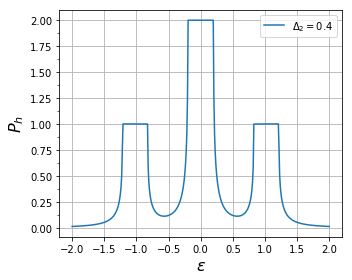

In [23]:
# T matrix with Z
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Z=0.
# Esw= np.linspace(-1,1,100)*7*D1
Esw0= np.linspace(-2,2,400)

def Reh_calc(D1,D2):
    Ree0_u=np.zeros((len(Esw0),2))
    Ree0_d=np.zeros((len(Esw0),2))
    Reh0_u=np.zeros((len(Esw0),2))
    Reh0_d=np.zeros((len(Esw0),2))


    Ham=  - k0u* np.kron(sz,np.kron(s0,s_up))\
            - k0d* np.kron(sz,np.kron(s0,s_dn))\
            + D1*np.kron(sx,np.kron(sy,sy))\
            + D1t*np.kron(sy,np.kron(s0,sy))\
            + D2*np.kron(sy,np.kron(sy,s0))

    vk= vF*np.kron(s0,np.kron(sz,s0))
    Hd= np.linalg.inv(vk)


    for i_E in range(len(Esw0)):
        E=Esw0[i_E]
        Ht= np.dot(Hd,E*np.eye(8)-  Ham)
        evs, evecs = np.linalg.eig(Ht)

        i_evan= np.where( np.abs(np.imag(evs)) > 1e-5 )[0]
        ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
        ie_R= np.where( np.imag(evs[i_evan]) < 0)[0]

        i_prop= np.where( np.abs(np.imag(evs)) < 1e-5 )[0]
        evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
        Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[8,])
        ip_T= np.where( np.real(Jmat[i_prop]) > 0)[0]
        ip_R= np.where( np.real(Jmat[i_prop]) < 0)[0]

        i_T=np.concatenate((i_prop[ip_T],i_evan[ie_T]))
        i_R=np.concatenate((i_prop[ip_R],i_evan[ie_R]))

        evecs= np.dot(evecs,np.diag(1/Jmat**0.5))
        Tevecs = evecs[:,i_T]    
        Revecs = evecs[:,i_R]    
        evecs_0= np.concatenate((Tevecs,Revecs),axis=1)


        Revecs_l= np.kron(np.array([[0,1,0,0],[0,0,0,1]]).T,s0)
        Tevecs_l= np.kron(np.array([[1,0,0,0],[0,0,1,0]]).T,s0)
        evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

        Tmat=sp.linalg.solve(evecs_0,evecs_l)
#         Tz=[[1-1j*Z,0,-1j*Z,0],\
#             [0,1+1j*Z,0,-1j*Z],\
#             [1j*Z,0,1+1j*Z,0],\
#             [0,1j*Z,0,1-1j*Z]]
        Tz=[[np.cosh(Z),0,-1j*np.sinh(Z),0],\
            [0,np.cosh(Z),0,-1j*np.sinh(Z)],\
            [1j*np.sinh(Z),0,np.cosh(Z),0],\
            [0,1j*np.sinh(Z),0,np.cosh(Z)]]
        Tt=np.dot(Tmat,np.kron(Tz,s0))
        TLL=Tt[np.ix_([4,5,6,7],[4,5,6,7])]
        TLR=Tt[np.ix_([4,5,6,7],[0,1,2,3])]
        x= -sp.linalg.solve(TLL,TLR)
    #     x= -np.dot(np.linalg.inv(TLL),TLR)
        Ree0_u[i_E,:] = np.abs(x[0,0:2])**2
        Ree0_d[i_E,:] = np.abs(x[1,0:2])**2
        Reh0_u[i_E,:] = np.abs(x[2,0:2])**2
        Reh0_d[i_E,:] = np.abs(x[3,0:2])**2

    #     print(Ree[i_E],Reh[i_E])

    return Ree0_u,Ree0_d,Reh0_u,Reh0_d

fig, ax = plt.subplots(figsize=(5,4))

D21=0.2
Ree1_u,Ree1_d,Reh1_u,Reh1_d= Reh_calc(D1=D1,D2=D21)
# plt.plot(Esw0, Reh1_u)
# plt.plot(Esw0, Reh1_d)

# plt.plot(Esw0,Reh1,label='$\Delta_2=%.1f$' % (D21))

D22=0.4
Ree2_u,Ree2_d,Reh2_u,Reh2_d= Reh_calc(D1=D1,D2=D21)
# plt.plot(Esw0, Reh2_u)
# plt.plot(Esw0, Reh2_d)
# plt.plot(Esw0,np.sum(Reh2_u+Reh2_d,axis=1),label='$\Delta_2=%.1f$' % (D22))
plt.plot(Esw0,np.sum(Reh2_u+Reh2_d,axis=1),label='$\Delta_2=%.1f$' % (D22))
# plt.plot(Esw0,Reh2_d,label='$\Delta_2=%.1f$' % (D22))


ax.legend()
fsize=16
plt.ylabel(r"$P_h$",fontsize = fsize)
plt.xlabel(r"$\varepsilon$",fontsize = fsize)
# plt.xticks(np.arange(-0.08,0.081,0.04))
# plt.yticks(np.arange(0,2.1,0.5))
# plt.legend(loc='upper right')
plt.grid()

ax.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.tight_layout()
# plt.savefig('figs/CAR_eff_nu2_vs_E.pdf')
plt.show()

In [33]:
# T matrix with random disorder

Nrep=100
Nimp=30
Uimp=1.0
L=10/D1
Zimp=0.2
Z=0.
Esw= np.linspace(-1,1,100)*7*D1

Ree=np.zeros((len(Esw),Nrep))
Reh=np.zeros((len(Esw),Nrep))

Ham=  - k0u* np.kron(sz,np.kron(s0,s_up))\
        - k0d* np.kron(sz,np.kron(s0,s_dn))\
        + D1*np.kron(sy,np.kron(sx,sy))\
        + D1t*np.kron(sy,np.kron(s0,sy))\
        + D2*np.kron(sy,np.kron(sy,s0))

vk= np.kron(s0,np.kron(sz,s0))
Hd= np.linalg.inv(vk)


for i_E in range(len(Esw)):
    E=Esw[i_E]
    Ht= np.dot(Hd,E*np.eye(8)-  Ham)
    evs, evecs = np.linalg.eig(Ht)

    evecs_inv=np.linalg.inv(evecs)
    #     evecs_inv=np.transpose(evecs)
    Jmat = np.reshape(np.diag(np.dot(evecs_inv,np.dot(vk,evecs))),[8,])
    evecs_0= np.dot(evecs,np.diag(1/Jmat**0.5))
    
    Revecs_l= np.kron(np.array([[0,1,0,0],[0,0,0,1]]).T,s0)
    Tevecs_l= np.kron(np.array([[1,0,0,0],[0,0,1,0]]).T,s0)
    evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)
    
    Tl=evecs_l
    Tr=np.linalg.inv(evecs_l)
#     Tl=sp.linalg.solve(evecs_0,evecs_l)
#     Tr=sp.linalg.solve(evecs_l,evecs_0)
    Tz=[[1-1j*Z,0,-1j*Z,0],\
        [0,1+1j*Z,0,-1j*Z],\
        [1j*Z,0,1+1j*Z,0],\
        [0,1j*Z,0,1-1j*Z]]
    Tz=np.kron(Tz,s0)
#     Ts=[[1-1j*Zimp,0,-1j*Zimp,0],\
#         [0,1+1j*Zimp,0,-1j*Zimp],\
#         [1j*Zimp,0,1+1j*Zimp,0],\
#         [0,1j*Zimp,0,1-1j*Zimp]]
#     Ts=np.linalg.inv(Ts)
#     Ts=sp.linalg.expm(1j*Uimp*np.dot(Hd,np.kron(sz,sz)))

    def Asc(x):
        return np.dot(evecs,np.dot(np.diag(np.exp(1j*evs*x)),evecs_inv))
        
    for i_r in range(Nrep):

        x_imp=np.sort(np.random.rand(Nimp)*L)
        x_imp=np.concatenate(([0],x_imp))
        
#         Tmat=np.dot(Tl,Tz)
        Tmat=np.dot(Tl,Tz) #np.eye(4)
        for i_n in range(1,Nimp+1):
            Ur=np.random.rand()-0.5
            Ts=sp.linalg.expm(1j*Uimp*Ur*np.dot(Hd,np.kron(sz,np.kron(sx,s0))))
#             Ts=sp.linalg.expm(1j*Uimp*Ur*np.dot(Hd,np.kron(sz,np.kron(s0,s0))))
            Tmat=np.dot(Ts,np.dot(Asc(x_imp[i_n]-x_imp[i_n-1]),Tmat))
        Tmat=np.dot(Asc(L-x_imp[Nimp]),Tmat)
        Tt=np.dot(Tr,Tmat)
        TLL=Tt[np.ix_([4,5,6,7],[4,5,6,7])]
        TLR=Tt[np.ix_([4,5,6,7],[0,1,2,3])]
        x= -sp.linalg.solve(TLL,TLR)
        Ree[i_E,i_r] = np.sum(np.abs(x[0,0:2])**2+np.abs(x[1,0:2])**2)
        Reh[i_E,i_r] = np.sum(np.abs(x[2,0:2])**2+np.abs(x[3,0:2])**2)

print('Done!')

Done!


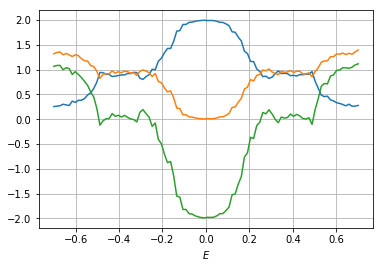

In [34]:
plt.figure()
# plt.plot(Esw,Reh)
# plt.plot(Esw,Ree)
plt.plot(Esw,np.mean(Reh,1))
plt.plot(Esw,np.mean(Ree,1))
plt.plot(Esw,-np.mean(Reh,1)+np.mean(Ree,1))
plt.grid()
# plt.ylim(0,1.1)

plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E$')
plt.show()

In [56]:
# T matrix with random disorder

Nrep=10
Nimp=80
L=40/D2
dl=L/Nimp
Z=0.4
Esw= np.linspace(-4.1,4.1,30)

Ree=np.zeros((len(Esw),Nrep))
Reh=np.zeros((len(Esw),Nrep))

vk= np.kron(s0,np.kron(sz,s0))
Hd= np.linalg.inv(vk)

Dmat=(np.random.rand(Nimp,Nrep)-0.5)
D1s=D1*Dmat
D2s=D2*Dmat

Revecs_l= np.kron(np.array([[0,1,0,0],[0,0,0,1]]).T,s0)
Tevecs_l= np.kron(np.array([[1,0,0,0],[0,0,1,0]]).T,s0)
evecs_l= np.concatenate((Tevecs_l,Revecs_l),axis=1)

Tl=evecs_l
Tr=np.linalg.inv(evecs_l)
Tz=[[1-1j*Z,0,-1j*Z,0],\
    [0,1+1j*Z,0,-1j*Z],\
    [1j*Z,0,1+1j*Z,0],\
    [0,1j*Z,0,1-1j*Z]]
Tz=np.kron(Tz,s0)

for i_r in range(Nrep):
    print(i_r,end='\r')
    
    for i_E in range(len(Esw)):
        E=Esw[i_E]
        
        Tmat=np.dot(Tl,Tz)
        for i_n in range(Nimp):

            Ham=  - k0u* np.kron(sz,np.kron(s0,s_up))\
                    - k0d* np.kron(sz,np.kron(s0,s_dn))\
                    + D1s[i_n,i_r]*np.kron(sy,np.kron(sx,sy))\
                    + D1t*np.kron(sy,np.kron(s0,sy))\
                    + D2s[i_n,i_r]*np.kron(sy,np.kron(sy,s0))

            Tmat=np.dot(sp.linalg.expm(1j*np.dot(Hd,E*np.eye(8)-  Ham)*dl),Tmat)
            
        Tt=np.dot(Tr,Tmat)
        TLL=Tt[np.ix_([4,5,6,7],[4,5,6,7])]
        TLR=Tt[np.ix_([4,5,6,7],[0,1,2,3])]
        x= -sp.linalg.solve(TLL,TLR)
        Ree[i_E,i_r] = np.sum(np.abs(x[0,0:2])**2+np.abs(x[1,0:2])**2)
        Reh[i_E,i_r] = np.sum(np.abs(x[2,0:2])**2+np.abs(x[3,0:2])**2)


print('Done!')

Done!


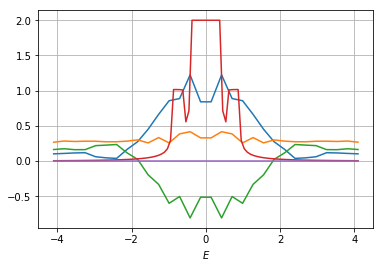

In [57]:
plt.figure()
# plt.plot(Esw,Reh)
# plt.plot(Esw,Ree)
plt.plot(Esw,np.mean(Reh,1))
plt.plot(Esw,np.mean(Ree,1))
plt.plot(Esw,-np.mean(Reh,1)+np.mean(Ree,1))

plt.plot(Esw0,Reh0[:,0]+Reh0[:,1])
plt.plot(Esw0,Ree0[:,0]+Ree0[:,1])

x=np.mean(Ree,1)-np.mean(Reh,1)
# plt.plot(Esw,x/(1-x))

plt.grid()
# plt.ylim(-1,1.1)

plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E$')
plt.show()